# PO Agent API (Agentic Tool-Calling Only)

Notebook version of your `po_app_agentic_only.py`. Cells are organized into logical sections so you can run or tweak pieces independently.

## Optional: Install dependencies (only if needed)

In [73]:
# Uncomment and run if your environment doesn't have these yet
# %pip install fastapi uvicorn 'sqlalchemy<2.0' langgraph langchain-openai langchain-core python-dotenv requests
# %pip install pyodbc


## Imports & Environment

In [74]:
from __future__ import annotations

import os, re, json, urllib.parse
from typing import Dict, Optional
from uuid import uuid4
from datetime import datetime, timedelta, timezone
from zoneinfo import ZoneInfo

import requests
from dotenv import load_dotenv, find_dotenv
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import JSONResponse
from pydantic import BaseModel, Field
from sqlalchemy import create_engine, text

# LangGraph (agentic tool-calling)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, MessagesState  # <-- IMPORTANT

# LangChain
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import AIMessage, BaseMessage
from langchain.chat_models import init_chat_model

# Azure OpenAI (embeddings for search)
from openai import AzureOpenAI
from IPython.display import Image, display


# Helpers (make sure these modules are available in your PYTHONPATH)
from helper.currency_helper import _extract_price_currency
from helper.po_helpers import _insert_purchase_order, _generate_po_pdf

# Load environment variables
load_dotenv(find_dotenv(), override=True)


True

## Database engine

In [75]:
DB_DATABASE = os.getenv("DB_DATABASE")
DB_USER     = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DRIVER_PATH = "/opt/homebrew/opt/msodbcsql18/lib/libmsodbcsql.18.dylib"

ODBC_STR = (
    "Driver={{{driver_path}}};".format(driver_path=DRIVER_PATH) +
    f"Server=tcp:ramdemosql.database.windows.net,1433;"
    f"Database={DB_DATABASE};"
    f"Uid={DB_USER};"
    f"Pwd={DB_PASSWORD};"
    "Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;"
)

_engine = None
def _get_engine():
    global _engine
    if _engine is not None:
        return _engine
    db_url = "mssql+pyodbc:///?odbc_connect=" + urllib.parse.quote_plus(ODBC_STR)
    _engine = create_engine(db_url, pool_pre_ping=True, pool_recycle=1800)
    return _engine


## Azure Search & Azure OpenAI clients

In [76]:
AZURE_SEARCH_ENDPOINT = os.getenv("AZURE_SEARCH_ENDPOINT")
AZURE_SEARCH_KEY = os.getenv("AZURE_SEARCH_KEY")
AZURE_SEARCH_INDEX = os.getenv("INDEX_NAME") or "po-policy-index"

AOAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AOAI_KEY = os.getenv("AZURE_OPENAI_API_KEY")
EMBEDDING_MODEL = os.getenv("EMBEDDING_ENGINE") or "text-embedding-ada-002"

if not (AOAI_ENDPOINT and AOAI_KEY and AZURE_SEARCH_ENDPOINT and AZURE_SEARCH_KEY):
    raise ValueError("Missing Azure env vars (OPENAI endpoint/key or SEARCH endpoint/key).")

aoai_client = AzureOpenAI(api_key=AOAI_KEY, azure_endpoint=AOAI_ENDPOINT, api_version="2024-05-01-preview")

# Chat LLM (tool-calling)
AZURE_CHAT_DEPLOYMENT = os.getenv("DEPLOYMENT_NAME") or "gpt-35-turbo"
llm = init_chat_model("azure_openai:gpt-35-turbo", azure_deployment=AZURE_CHAT_DEPLOYMENT)

# Tavily
TAVILY_ENDPOINT = "https://api.tavily.com/search"
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Timezone for “today”
LOCAL_TZ = ZoneInfo(os.getenv("LOCAL_TZ", "Europe/London"))


## Utilities

In [77]:
def _normalize_product(name: str) -> str:
    n = re.sub(r"\b(Product|laptop|pc|pcs|computer)s?\b$", "", name.strip(), flags=re.I)
    return n.strip().upper()

def _last_assistant_text(messages) -> str:
    for m in reversed(messages or []):
        if isinstance(m, AIMessage):
            return getattr(m, "content", "") or ""
        if isinstance(m, dict) and m.get("role") == "assistant":
            return m.get("content", "")
    if not messages: return ""
    m = messages[-1]
    return getattr(m, "content", m.get("content", "")) if isinstance(m, dict) else getattr(m, "content", "")

def interrupt_text(obj) -> str:
    if isinstance(obj, list):
        for x in obj:
            if hasattr(x, "value"): return str(x.value)
        return str(obj[0]) if obj else ""
    if hasattr(obj, "value"): return str(obj.value)
    if isinstance(obj, dict) and "value" in obj: return str(obj["value"])
    return str(obj)


## Tools

In [78]:
# ---------------------- POLICY LOOKUP TOOL ----------------------
@tool
def policy_lookup(query: str) -> str:
    """Vector-search policy docs; returns short bulleted text."""
    emb = aoai_client.embeddings.create(model=EMBEDDING_MODEL, input=query)
    query_vector = emb.data[0].embedding
    url = f"{AZURE_SEARCH_ENDPOINT}/indexes/{AZURE_SEARCH_INDEX}/docs/search?api-version=2024-07-01"
    headers = {"Content-Type": "application/json", "api-key": AZURE_SEARCH_KEY}
    payload = {
        "vectorQueries": [{"kind":"vector","vector":query_vector,"fields":"contentVector","k":5}],
        "select": "title,content"
    }
    try:
        resp = requests.post(url, headers=headers, json=payload, timeout=20)
        if resp.status_code != 200:
            return f"Policy lookup error: {resp.text}"
        data = resp.json()
        print("policy_lookup response:", data)
    except Exception as e:
        return f"Policy lookup error: {e}"
    items = []
    for doc in data.get("value", []):
        items.append(f"- {doc.get('title','')}: {doc.get('content','')}")
    return "\n".join(items) if items else "No relevant policy found."

# ---------------------- INVENTORY CHECK TOOL ----------------------
@tool
def check_availability(product: str) -> Dict:
    """Return availability + unit price from procurement.Inventory."""
    eng = _get_engine()
    norm = _normalize_product(product)
    with eng.connect() as conn:
        row = conn.execute(
            text("SELECT Product, Available, UnitPrice FROM procurement.Inventory WHERE UPPER(Product) = :p"),
            {"p": norm}
        ).first()
        if not row:
            row = conn.execute(
                text("""SELECT TOP 1 Product, Available, UnitPrice
                        FROM procurement.Inventory
                        WHERE UPPER(Product) LIKE :p
                        ORDER BY Product"""),
                {"p": norm + "%"}
            ).first()
    if row:
        try:
            Product = row.Product; 
            available = int(row.Available); 
            unit_price = float(row.UnitPrice)
            print(f"check_availability found: {Product} avail={available} price={unit_price}")
        except Exception:
            Product, available, unit_price = row[0], int(row[1]), float(row[2])
        return {"product": Product, "available": available, "unit_price": unit_price}
    return {"product": norm, "available": 0, "unit_price": 0.0}

# ---------------------- WEB PRODUCT SEARCH (TAVILY) ----------------------
@tool
def search_products(query: str, filters: Optional[Dict] = None) -> Dict:
    """Search web for product pricing (via Tavily). Returns {candidates[], unit_price_hint, vendor_name, vendor_url}."""
    api_key = (os.getenv("TAVILY_API_KEY") or "").strip()
    if not api_key:
        return {"error": "TAVILY_API_KEY missing/invalid", "candidates": [], "unit_price_hint": None, "vendor_name": None, "vendor_url": None}

    filters = filters or {}
    currency = (filters.get("currency") or "GBP").upper()
    max_results = int(filters.get("max_results") or 8)
    include_domains = filters.get("include_domains")

    TAVILY_ENDPOINT = "https://api.tavily.com/search"
    headers = {"Content-Type":"application/json","Accept":"application/json","Authorization":f"Bearer {api_key}"}
    payload = {
        "query": query, "search_depth": "advanced",
        "max_results": max(1, min(max_results, 10)),
        "include_answer": False, "include_images": False, "topic": "general",
    }
    if include_domains: payload["include_domains"] = include_domains

    try:
        session = requests.Session(); session.trust_env = False
        resp = session.post(TAVILY_ENDPOINT, headers=headers, json=payload, timeout=30)
        if resp.status_code != 200:
            return {"error": f"Tavily error {resp.status_code}: {resp.text}", "candidates": [], "unit_price_hint": None, "vendor_name": None, "vendor_url": None}
        data = resp.json()
    except Exception as e:
        return {"error": f"Tavily request failed: {e}", "candidates": [], "unit_price_hint": None, "vendor_name": None, "vendor_url": None}

    results = data.get("results", []) or []
    candidates = []
    best = None

    for r in results:
        url = r.get("url","") or ""
        title = r.get("title","") or ""
        content = r.get("content","") or ""
        domain = urllib.parse.urlparse(url).netloc
        price, cur = _extract_price_currency(f"{title} {content}", currency_hint=currency)
        cand = {"title": title[:200], "vendor": domain, "price": price, "currency": cur or currency, "url": url, "source": "tavily"}
        candidates.append(cand)
        if isinstance(price, (int, float)) and best is None:
            best = cand

    priced = [c for c in candidates if isinstance(c.get("price"), (int,float))]
    priced.sort(key=lambda x: x["price"])
    if priced:
        best = priced[0]

    return {
        "query": query,
        "candidates": (priced if priced else candidates)[:max_results],
        "unit_price_hint": (best.get("price") if best else None),
        "vendor_name": (best.get("vendor") if best else None),
        "vendor_url": (best.get("url") if best else None),
    }

# ---------------------- PURCHASE ORDER ACTIVITY SUMMARY ----------------------
@tool
def po_activity_summary(date_str: Optional[str] = None) -> Dict:
    """Summarize Purchase Orders for a specific local date (defaults to 'today' in Europe/London)."""
    try:
        if date_str:
            y, m, d = map(int, date_str.split("-"))
            start_local = datetime(y, m, d, 0, 0, 0, tzinfo=LOCAL_TZ)
        else:
            now_local = datetime.now(LOCAL_TZ)
            start_local = now_local.replace(hour=0, minute=0, second=0, microsecond=0)
        end_local = start_local + timedelta(days=1)
    except Exception:
        now_local = datetime.now(LOCAL_TZ)
        start_local = now_local.replace(hour=0, minute=0, second=0, microsecond=0)
        end_local = start_local + timedelta(days=1)

    start_utc = start_local.astimezone(timezone.utc)
    end_utc = end_local.astimezone(timezone.utc)

    eng = _get_engine()
    table_candidates = [
        "procurement.PurchaseOrders",
        "procurement.PO",
        "dbo.PurchaseOrders",
        "PurchaseOrders",
    ]

    rows = []
    last_error = None
    with eng.connect() as conn:
        for tbl in table_candidates:
            try:
                q = text(f"""
                    SELECT PoNumber, Product, Quantity, UnitPrice, VendorName, VendorUrl, CreatedAt
                    FROM {tbl}
                    WHERE CreatedAt >= :start AND CreatedAt < :end
                    ORDER BY CreatedAt DESC
                """)
                res = conn.execute(q, {"start": start_utc, "end": end_utc}).fetchall()
                if res:
                    for r in res:
                        try:
                            rows.append({
                                "po":      r.PoNumber,
                                "product": r.Product,
                                "qty":     int(r.Quantity),
                                "unit":    float(r.UnitPrice),
                                "total":   float(r.Quantity) * float(r.UnitPrice),
                                "vendor":  getattr(r, "VendorName", None),
                                "url":     getattr(r, "VendorUrl", None),
                                "ts":      str(getattr(r, "CreatedAt", "")),
                            })
                        except Exception:
                            po, prod, qty, unit, vname, vurl, ts = r
                            rows.append({
                                "po": po, "product": prod, "qty": int(qty),
                                "unit": float(unit), "total": float(qty) * float(unit),
                                "vendor": vname, "url": vurl, "ts": str(ts),
                            })
                    break
                else:
                    rows = []
                    break
            except Exception as e:
                last_error = str(e)
                continue

    total_orders = len(rows)
    total_units = sum(r["qty"] for r in rows)
    total_spend = sum(r["total"] for r in rows)

    top_map: Dict[str, Dict[str, float]] = {}
    for r in rows:
        p = r["product"]
        t = top_map.setdefault(p, {"qty": 0, "spend": 0.0})
        t["qty"] += r["qty"]
        t["spend"] += r["total"]
    top_items = sorted(
        [{"product": k, "qty": int(v["qty"]), "spend": float(v["spend"])} for k, v in top_map.items()],
        key=lambda x: (x["qty"], x["spend"]), reverse=True
    )[:5]

    result = {
        "date": start_local.date().isoformat(),
        "total_orders": total_orders,
        "total_units": total_units,
        "total_spend": round(total_spend, 2),
        "top_items": top_items,
        "orders": rows,
    }
    if total_orders == 0 and last_error:
        result["note"] = f"No orders found and last table error: {last_error}"
    return result

# ---------------------- PURCHASE ORDER APPROVAL TOOL (HITL) ----------------------
@tool
def purchaseorder_approval(
    product: str,
    quantity: int,
    policy_summary: Optional[str] = None,
    unit_price_hint: Optional[float] = 100,
    vendor_name: Optional[str] = None,
    vendor_url: Optional[str] = None
) -> Dict:
    """Final approval + PO creation. Uses interrupt() for approvals/price if needed."""
    eng = _get_engine()
    norm = _normalize_product(product)
    vendor_name = (vendor_name or "N/A")[:200]
    vendor_url = vendor_url or "N/A"
    unit_price_hint = unit_price_hint
    policy_summary = policy_summary or "(No policy summary provided)"

    with eng.connect() as conn:
        row = conn.execute(
            text("SELECT Product, Available, UnitPrice FROM procurement.Inventory WHERE UPPER(Product)=:p"),
            {"p": norm}
        ).first()

        if not row:
            print(f"'{product}' not in inventory; need unit price. unit price: {unit_price_hint}")
            if unit_price_hint is None:
                price_input = interrupt(f"'{product}' is not in inventory.\nPlease provide a unit price (number only)?")
                unit_price = float(str(price_input).strip())
            else:
                unit_price = float(unit_price_hint)

            conn.execute(
                text("INSERT INTO procurement.Inventory (Product, Available, UnitPrice) VALUES (:Product, :available, :unit_price)"),
                {"Product": norm, "available": quantity, "unit_price": unit_price}
            ); conn.commit()

            Product = norm; total = unit_price * quantity

            if total <= 5000:
                approve = "yes"
            else:
                approve = interrupt(
                    f"Approve buying {quantity} {Product} at £{unit_price:.2f} each (total £{total:.2f})? (Yes/No)\n\nPolicy Summary:\n{policy_summary}"
                )
            if str(approve).strip().lower() != "yes":
                return {"message": "Buying declined.", "__end__": True}

            po_number, _ = _insert_purchase_order(
                eng, Product=Product, quantity=quantity, unit_price=unit_price,
                vendor_name=vendor_name, vendor_url=vendor_url
            )
            _generate_po_pdf(po_id=po_number, Product=Product, quantity=quantity, unit_price=unit_price,
                             total_price=total, vendor_name=vendor_name, vendor_url=vendor_url)

            conn.execute(text("UPDATE procurement.Inventory SET Available = Available + :qty WHERE UPPER(Product) = :Product"),
                         {"qty": quantity, "Product": norm}); conn.commit()
            return {"message": f"Order placed and inventory seeded. PO Number: {po_number}", "__end__": True}

        # in inventory
        Product, available, unit_price = row.Product, int(row.Available), float(row.UnitPrice)
        if quantity > available:
            return {"message": f"Only {available} of {Product} available. Buying declined.", "__end__": True}

        total = unit_price * quantity
        if total <= 500:
            approve = "yes"
        elif total <= 5000:
            approve = interrupt(
                f"Approve buying {quantity} {Product} (stock: {available}) at £{unit_price:.2f} each "
                f"(total £{total:.2f})? (Yes/No)\n\nPolicy Summary:\n{policy_summary}"
            )
        else:
            return {"message": f"Order total £{total:.2f} exceeds limit and requires finance approval.", "__end__": True}

        if str(approve).strip().lower() != "yes":
            return {"message": "Buying declined.", "__end__": True}

        po_number, _ = _insert_purchase_order(
            eng, Product=Product, quantity=quantity, unit_price=unit_price,
            vendor_name=vendor_name, vendor_url=vendor_url
        )
        _generate_po_pdf(po_id=po_number, Product=Product, quantity=quantity, unit_price=unit_price,
                         total_price=total, vendor_name=vendor_name, vendor_url=vendor_url)

        with eng.connect() as conn2:
            conn2.execute(text("UPDATE procurement.Inventory SET Available = Available + :qty WHERE UPPER(Product) = :Product"),
                          {"qty": quantity, "Product": Product.upper()})
            conn2.commit()

        return {"message": f"Order placed, inventory updated, and PO generated. PO: {po_number}", "__end__": True}


## Agentic tool-calling graph

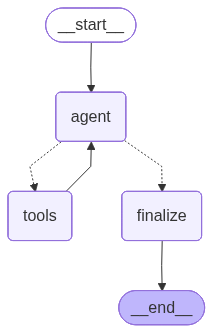

In [79]:
TOOLS = [policy_lookup, check_availability, search_products, po_activity_summary, purchaseorder_approval]

AGENTIC_SYSTEM = (
    "You are a procurement assistant. Use tools to stay factual.\n"
    "When to use each tool:\n"
    "- policy_lookup: rules/thresholds/approvals (always for policy; it returns a summary or fallback).\n"
    "- check_availability: stock/price from inventory.\n"
    "- search_products: web price lookup (if not in inventory); pass its unit_price_hint/vendor fields into purchaseorder_approval.\n"
    "- purchaseorder_approval: create/buy via PO; pass policy_summary and, when available, unit_price_hint/vendor fields.\n"
    "- po_activity_summary: daily PO summary / counts / spend.\n"
    "For buy/PO requests: first call policy_lookup for policy summary, then call search_products(if product not in inventory) for unit_price_hint/vendor fields fields into purchaseorder_approval.\n"
    "Prefer tool facts; answer concisely."
)

def agent_node(state: MessagesState) -> dict:
    msgs = state.get("messages", [])
    ai = llm.bind_tools(TOOLS).invoke(msgs)
    print("[agent_node] tool_calls:", getattr(ai, "tool_calls", None))
    return {"messages": [ai]}   # append assistant message

tool_node = ToolNode(TOOLS)

def should_continue(state: MessagesState) -> str:
    msgs = state.get("messages", [])
    # If the last assistant message requested tool calls → go to tools
    if msgs:
        last = msgs[-1]
        if isinstance(last, AIMessage) and getattr(last, "tool_calls", None):
            return "tools"
        if isinstance(last, dict) and last.get("tool_calls"):
            return "tools"
    # Otherwise, we’re done
    return "finalize"

def finalize_node(state: MessagesState) -> MessagesState:
    return state

agent_wf = StateGraph(MessagesState)
agent_wf.add_node("agent", agent_node)
agent_wf.add_node("tools", tool_node)
agent_wf.add_node("finalize", finalize_node)
agent_wf.set_entry_point("agent")
agent_wf.add_conditional_edges("agent", should_continue, {
    "tools": "tools",
    "finalize": "finalize",
})
agent_wf.add_edge("tools", "agent")

agent_memory = MemorySaver()
agent_graph = agent_wf.compile(checkpointer=agent_memory)


display(Image(agent_graph.get_graph().draw_mermaid_png()))


## FastAPI app & endpoint

In [80]:
app = FastAPI(title="PO Agent API (Agentic Tool-Calling Only)", version="3.1.0")
app.add_middleware(CORSMiddleware, allow_origins=["*"], allow_credentials=True, allow_methods=["*"], allow_headers=["*"])

class ChatRequest(BaseModel):
  Question: Optional[str] = Field(None)
  decision: Optional[str] = Field(None)
  conversation_id: Optional[str] = Field(None)

@app.post("/agnt/chat")
def agnt_agent(req: ChatRequest):
    thread_id = req.conversation_id or f"agent_thread:{uuid4()}"
    config = RunnableConfig(configurable={"thread_id": thread_id})

    # Resume HITL interrupts (e.g., approvals / manual price)
    if req.decision:
        state = agent_graph.invoke(Command(resume=str(req.decision).strip().lower()), config=config)
        return JSONResponse({"status":"DONE","thread_id":thread_id,"message":_last_assistant_text(state.get("messages", []))})

    question = (req.Question or "").strip()
    if not question:
        return JSONResponse({"status":"ERROR","error":"Question is required"}, status_code=400)

    # First turn: include system message. Subsequent turns: user only.
    msgs = [{"role": "user", "content": question}]
    if not req.conversation_id:
        msgs = [{"role": "system", "content": AGENTIC_SYSTEM}] + msgs

    # Run agentic loop
    state = agent_graph.invoke({"messages": msgs}, config=config)  # type: ignore

    if "__interrupt__" in state:
        prompt = interrupt_text(state["__interrupt__"])
        return JSONResponse({"status":"APPROVAL_REQUIRED", "thread_id": thread_id, "prompt": prompt})

    return JSONResponse({"status":"DONE","thread_id":thread_id,"message":_last_assistant_text(state.get("messages", []))})


## (Optional) Run the API server inline

In [81]:
# Running uvicorn inside a notebook (stop the cell to terminate the server)
# import uvicorn
# uvicorn.run(app, host="0.0.0.0", port=8000, reload=False)
